<a href="https://colab.research.google.com/github/pko89403/Pytorch_SelfStudy/blob/master/3D_Conv_Example_Using_MNIST3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Feb 27 13:32:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 3D-MNIST 이미지 데이터 셋으로 이미지 분류
medium.com/shashwats-blog/3d-mnist-b922a3d07334
## Introduction 
MNIST는 비전 분야에서 Hello World 급의 데이터셋이다.    
3D MNIST는 Hello World 급의 데이터는 아니고    
2D의 MNIST Image가 Point Cloud(3D Scanner의 결과값)로 표현되어진 데이터 
HDF5 파일 포맷이다, 데이터셋은 다음과 같은 네가지를 포함하고 있음

- "points" 데이터셋 : x, y, z
- "normals" 데이터셋 : nx, ny, nz
- "img" 데이터셋 : 원래 MNIST 이미지
- "label" attribute : 원래 MNIST 라벨

https://drive.google.com/drive/folders/1Ma0bnGcDUUKA1-I1K7B6ady3KtgSjMZU?usp=sharing

In [0]:
mnist_3d_folder = "/content/drive/My Drive/mnist_3d"

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
with h5py.File(mnist_3d_folder+'/full_dataset_vectors.h5', 'r') as dataset:
  x_train = dataset["X_train"][:]
  x_test = dataset["X_test"][:]
  y_train = dataset["y_train"][:]
  y_test = dataset["y_test"][:]

In [5]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:  (2000, 4096)
y_test shape:  (2000,)


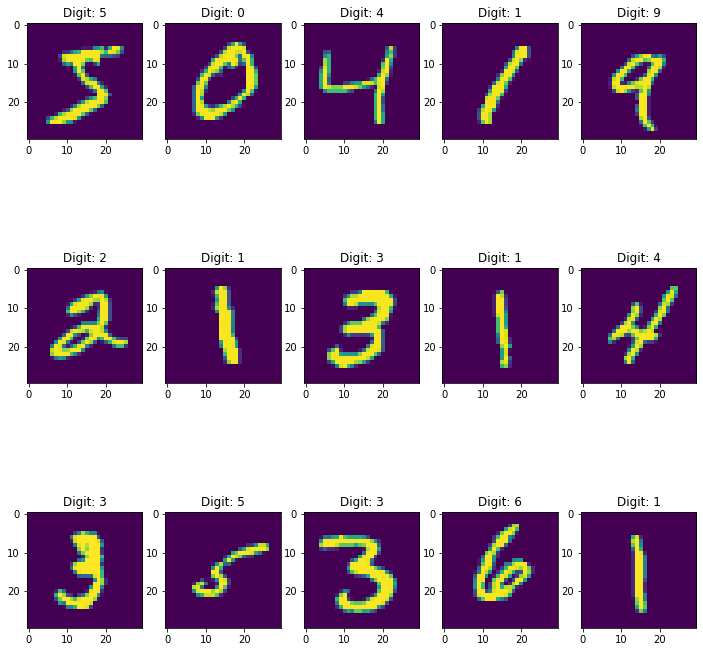

In [6]:
digits = []
with h5py.File(mnist_3d_folder+'/train_point_clouds.h5', 'r') as points_dataset:
  # digit 의 그룹 컨텐츠를 저장함  
  for i in range(15):
    digit = (points_dataset[str(i)]['img'][:],
             points_dataset[str(i)]['points'][:],
             points_dataset[str(i)].attrs['label'])
    digits.append(digit)

# 2D MNIST의 plot을 그려보자
fig, axs = plt.subplots(3,5,figsize=(12,12),facecolor='w',edgecolor='k')
fig.subplots_adjust(hspace=.5, wspace=.2)
for ax, d in zip(axs.ravel(), digits):
  ax.imshow(d[0][:])
  ax.set_title("Digit: " + str(d[2]))

이 데이터셋은 flat한 1차원 데이터지만, 그러나 다른 파일에는 x, y, z도 있다.   
3D 공간에 digit을 그림. 돌려 가면서 볼 수 있다. 

In [7]:
with h5py.File(mnist_3d_folder+'/train_point_clouds.h5', 'r') as points_dataset:
  digits = []
  for i in range(10):
    digit = (points_dataset[str(i)]['img'][:],
             points_dataset[str(i)]['points'][:],
             points_dataset[str(i)].attrs['label'])
    digits.append(digit)

x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]
trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, 
                      mode='markers',
                      marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.7))
data = [trace1]
layout = go.Layout(height=500, width=600, title='Digit: ' + str(digits[0][2]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

이 데이터셋을 사용해서 3D ConvNet을 구현한다.   
2차원 컨볼루션을 하려면, 데이터를 이미지를 width(너비), height(높이), channels 3차원으로 변형해야한다.   
여기서 channel은 R(Red), G(Green), B(Blue) 다.    
3차원 컨볼루션을 하려면, 데이터를 length, breadth, height, channel(r,g,b)인 4차원으로 변형해야한다.

In [0]:
# x_train.shape[0]이 10000 개 인걸 우리는 위에서 보았다. total_data_count
xtrain = np.ndarray((x_train.shape[0], 4096, 3)) 
xtest = np.ndarray((x_test.shape[0], 4096, 3))

def add_rgb_dimension(array):
  scaler_map = cm.ScalarMappable(cmap="Oranges")
  array = scaler_map.to_rgba(array)[:, : -1]
  return array

for i in range(x_train.shape[0]):
  xtrain[i] = add_rgb_dimension(x_train[i])
for i in range(x_test.shape[0]):
  xtest[i] = add_rgb_dimension(x_test[i])

## 1(total_data_count) + 4D 공간으로 데이터를 reshape 한다.
# 16 * 16 * 16 = 4096 이다.
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

# digit 데이터를 one-hot 인코딩을 진행한다.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [9]:
print("xtrain shape: ", xtrain.shape)
print("y_train shape: ", y_train.shape)
print("xtest shape: ", xtest.shape)
print("y_test shape: ", y_test.shape)

xtrain shape:  (10000, 16, 16, 16, 3)
y_train shape:  (10000, 10)
xtest shape:  (2000, 16, 16, 16, 3)
y_test shape:  (2000, 10)


입력과 출력 레이어를 구성 설명   
- 입력 레이어 : (16, 16, 16, 3)
- 출력 레이어 : ( 10 )   

컨볼루션 레이어
- 네 개의 컨볼루션 레이어를 사용한다. (8->16->32->64)의 필터 사이즈와 (3, 3, 3)의 커널 사이즈 
- 2개의 Max 풀링 레이어, 두번째와 네번째 컨볼루션 레이어 다음에 적용한다

멀티 레이어 퍼셉트론 레이어
- 배치 노말라이제이션을 컨볼루션 아키텍처에
- 덴스 레이어 (flatten -> 2048 -> 512)
- 오버 피팅 방지를 위해 중간에 드롭 아웃을 넣는다

In [10]:
## 입력 레이어
input_layer = keras.Input(shape=(16, 16, 16, 3))

## 컨볼루션 레이어 1, 2
conv_layer1 = layers.Conv3D(filters=8, kernel_size=(3,3,3), activation='relu')(input_layer)
conv_layer2 = layers.Conv3D(filters=16, kernel_size=(3,3,3), activation='relu')(conv_layer1)
# max 풀링 레이어 1
pooling_layer1 = layers.MaxPool3D(pool_size=(2,2,2))(conv_layer2)
## 컨볼루션 레이어 3, 4
conv_layer3 = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation='relu')(pooling_layer1)
conv_layer4 = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation='relu')(conv_layer3)
# max 풀링 레이어 2
pooling_layer2 = layers.MaxPool3D(pool_size=(2,2,2))(conv_layer4)
pooling_layer2 = layers.BatchNormalization()(pooling_layer2)
# 멀티 레이어 퍼셉트론에 넣기 위해 납작하게 만든다
# 예를 들어 (2,2)의 shape를 -> (4) shape로 만든다
flatten_layer = layers.Flatten()(pooling_layer2)

# 멀티 레이어 퍼셉트론 덴스 레이어로 
dense_layer1 = layers.Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = layers.Dropout(0.4)(dense_layer1)
dense_layer2 = layers.Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = layers.Dropout(0.4)(dense_layer2)
output_layer = layers.Dense(units=10, activation='softmax')(dense_layer2)

# 모델을 정의한다
model = keras.Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 16, 3)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 14, 14, 14, 8)     656       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 1, 1, 64)       0     

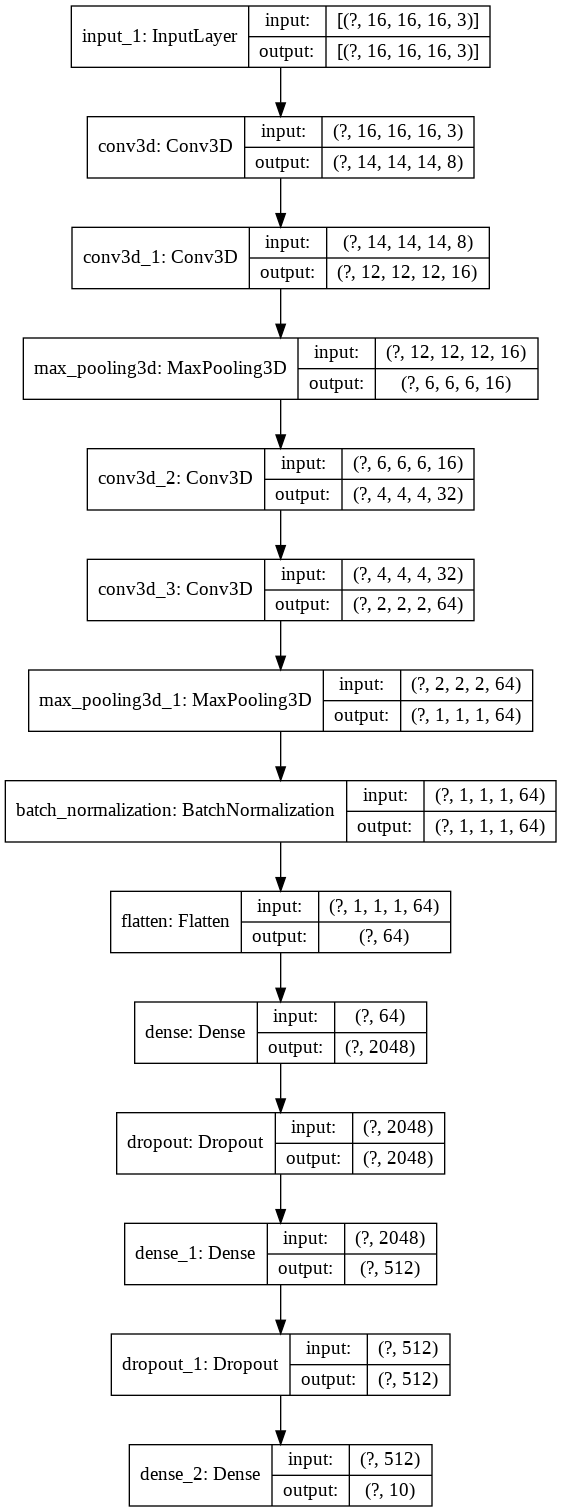

In [12]:
keras.utils.plot_model(model, 'Conv3D_Example_Model.png', show_shapes=True)

In [13]:
with tf.device('GPU'):
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
  model.fit(x=xtrain, 
            y=y_train, 
            batch_size=128, 
            epochs=50, 
            validation_split=0.2)
  test_scores = model.evaluate(xtest, y_test, verbose=2)
  print('Test Loss : ', test_scores[0])
  print('Test Accuracy : ', test_scores[1])

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 9s 1ms/sample - loss: 1.5466 - acc: 0.4535 - val_loss: 2.7235 - val_acc: 0.1660
Epoch 2/50
8000/8000 [==============================] - 3s 337us/sample - loss: 1.1043 - acc: 0.6080 - val_loss: 2.1762 - val_acc: 0.1735
Epoch 3/50
8000/8000 [==============================] - 3s 340us/sample - loss: 0.9950 - acc: 0.6472 - val_loss: 6.3589 - val_acc: 0.1190
Epoch 4/50
8000/8000 [==============================] - 3s 340us/sample - loss: 0.9277 - acc: 0.6756 - val_loss: 1.9725 - val_acc: 0.3410
Epoch 5/50
8000/8000 [==============================] - 3s 338us/sample - loss: 0.8425 - acc: 0.7036 - val_loss: 3.3402 - val_acc: 0.2360
Epoch 6/50
8000/8000 [==============================] - 3s 339us/sample - loss: 0.7775 - acc: 0.7289 - val_loss: 9.1135 - val_acc: 0.1485
Epoch 7/50
8000/8000 [==============================] - 3s 337us/sample - loss: 0.7157 - acc: 0.7485 - val_loss: 17.8466 - val